In [2]:
from google.colab import files
files.upload()  # Upload the downloaded `kaggle.json` here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mateusowczarek","key":"2ff49d2ddd28143ba1236a069fef4462"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Lock permissions

In [4]:
!kaggle datasets download -d shantanudhakadd/bank-customer-churn-prediction
!unzip bank-customer-churn-prediction.zip  # Unzip if needed

Dataset URL: https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction
License(s): other
Archive:  bank-customer-churn-prediction.zip
  inflating: Churn_Modelling.csv     


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [9]:
from google.colab import files
import pandas as pd

# Step 1: Upload the CSV file manually
uploaded = files.upload()  # Click "Choose Files" and select your dataset

# Step 2: Load the data (replace filename with your actual file name)
df = pd.read_csv(next(iter(uploaded)))  # Automatically gets the uploaded filename
print(df.head())

Saving Churn_Modelling.csv to Churn_Modelling (1).csv
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.5

In [14]:
# Check dataframe structure
print("Data shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Data shape: (10000, 14)

Column names: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

Data types:
 RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Missing values:
 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


Saving Churn_Modelling.csv to Churn_Modelling (5).csv
Original data shape: (10000, 14)

First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 6, 64)     │     19,200 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 6, 64)     │        128 │ lstm_1[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 6, 64)     │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 6, 64)     │          0 │ dropout_2[0][0],  │
│ (Attention)         │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 6, 64)     │        128 │ attention_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 6, 128)    │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ concatenate_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,777 (108.50 KB)

 Trainable params: 27,777 (108.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7008 - auc: 0.7590 - loss: 0.9471 - val_accuracy: 0.7375 - val_auc: 0.8439 - val_loss: 0.5290 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7437 - auc: 0.8307 - loss: 0.8088 - val_accuracy: 0.7800 - val_auc: 0.8490 - val_loss: 0.4848 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7616 - auc: 0.8368 - loss: 0.7878 - val_accuracy: 0.7675 - val_auc: 0.8510 - val_loss: 0.4760 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7850 - auc: 0.8550 - loss: 0.7494 - val_accuracy: 0.7935 - val_auc: 0.8446 - val_loss: 0.4526 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7870 - auc: 0.8599 - loss: 0.7316 - val_accuracy: 0.7550 - val_auc: 0.8467 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7688 - auc: 0

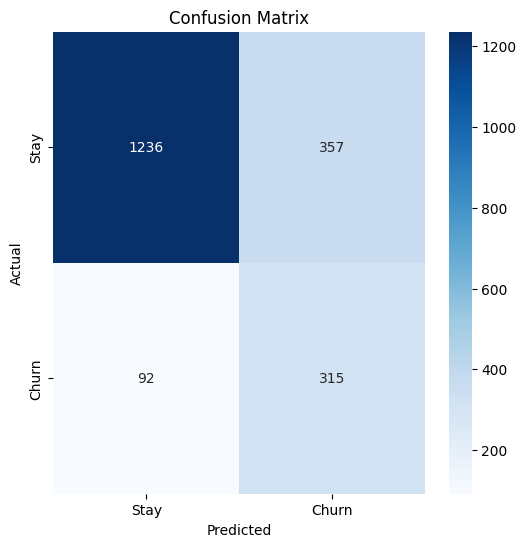

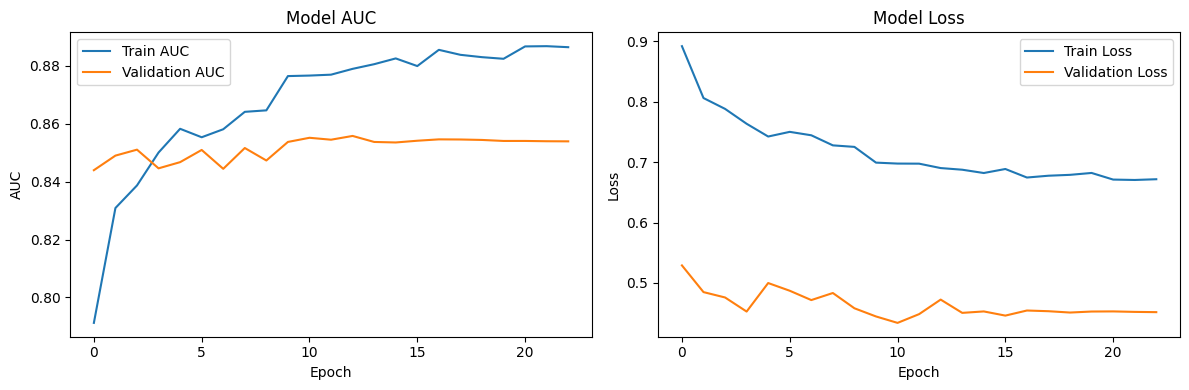

In [22]:
# Import required libraries
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 1. Upload and load data
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))
print("Original data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# 2. Data preprocessing
# Standardize column names
df = df.rename(columns={
    'CustomerId': 'customer_id',
    'Gender': 'gender',
    'Exited': 'churn',
    'NumOfProducts': 'products_number',
    'HasCrCard': 'credit_card',
    'IsActiveMember': 'active_member',
    'EstimatedSalary': 'estimated_salary',
    'Age': 'age',
    'Balance': 'balance',
    'Tenure': 'tenure'
})

# Convert categorical variables
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0}).astype('int8')
df['geography'] = df['Geography'].astype('category').cat.codes

# Create synthetic temporal sequences
np.random.seed(42)
customer_data = []
for cust_id in df['customer_id'].unique():
    base_data = df[df['customer_id'] == cust_id].iloc[0]
    for month in range(6):  # Create 6 months of historical data
        new_row = base_data.copy()
        # Add realistic variations
        new_row['CreditScore'] = max(300, min(850, new_row['CreditScore'] + np.random.randint(-15, 15)))
        new_row['balance'] *= np.random.uniform(0.9, 1.1)
        new_row['month'] = month
        customer_data.append(new_row)
df_seq = pd.DataFrame(customer_data)

# Select features
features = ['CreditScore', 'age', 'tenure', 'balance',
            'products_number', 'credit_card',
            'active_member', 'estimated_salary', 'gender', 'geography']
target = 'churn'

print("\nUsing features:", features)
print("Target variable:", target)

# 3. Create sequences with proper validation
def create_sequences(data, seq_length=6):
    sequences = []
    targets = []
    for cust_id in data['customer_id'].unique():
        cust_data = data[data['customer_id'] == cust_id].sort_values('month')
        if len(cust_data) >= seq_length:
            seq = cust_data.iloc[-seq_length:]  # Most recent sequence
            sequences.append(seq[features].values)
            targets.append(seq[target].iloc[-1])

    if len(sequences) == 0:
        raise ValueError("No valid sequences created. Check your data and sequence length.")

    return np.array(sequences), np.array(targets)

X, y = create_sequences(df_seq)
print("\nSequences shape:", X.shape)
print("Target shape:", y.shape)

# 4. Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 5. Build LSTM with Attention model
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM layer with return sequences
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    lstm_out = LayerNormalization()(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])
    attention = LayerNormalization()(attention)

    # Combine features
    combined = Concatenate()([lstm_out, attention])
    gap = tf.keras.layers.GlobalAveragePooling1D()(combined)

    # Classification head
    dense = Dense(64, activation='relu')(gap)
    dense = Dropout(0.2)(dense)
    outputs = Dense(1, activation='sigmoid')(dense)

    return Model(inputs, outputs)

model = build_model((X_train.shape[1], X_train.shape[2]))
model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model.summary()

# 6. Train model with proper callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight={0: 1., 1: len(y_train[y_train==0])/len(y_train[y_train==1])},
    callbacks=[
        EarlyStopping(
            monitor='val_auc',
            patience=10,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            mode='min',
            verbose=1
        )
    ],
    verbose=1
)

# 7. Evaluation and visualization
# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC score
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stay', 'Churn'],
            yticklabels=['Stay', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Training history visualization
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()